# Case Study: Used Car Price Prediction with Discount Motors

## Project Brief

You have been hired as a data scientist at Discount Motors, a used car dealership in the UK. The dealership is expanding and has hired a large number of junior salespeople. Although promising, these junior employees have difficulties pricing used cars that arrive at the dealership. **Sales have declined 18% in recent months, and management would like your help designing a tool to assist these junior employees.**

To start with, they would like you to work with the Toyota specialist to test your idea(s). They have collected some data from other retailers on the price that a range of Toyota cars were listed at. It is known that cars that are more than £1500 above the estimated price will not sell. The sales team wants to know whether you can make predictions within this range.

You will need to present your findings in two formats:
- You must submit a written report summarising your analysis to your manager. As a data science manager, your manager has a strong technical background and wants to understand what you have done and why. 
- You will then need to share your findings with the head of sales in a 10 minute presentation. The head of sales has no data science background but is familiar with basic data related terminology. 

The data you will use for this analysis can be accessed here: `"data/toyota.csv"`

## Presentation

- [**Data Science Manager Presentation**](./UsedCarPrediction_CaseStudy_20220701.pdf) >> page.13
- [**Sales Manager Presentation**](./UsedCarPrediction_CaseStudy_20220701.pdf) >> page.3
- [Alternative Link (if above links do not work)](https://github.com/aoot/Workspace_UsedCarPricePrediction/blob/4a2470e345eb3266d02d6c7b12c085dbd16ebf73/UsedCarPrediction_CaseStudy_20220701.pdf)

## Preview Dataset

__Findings:__
- The dataset has 6738 entries and 9 columns.
- Each of the column is of its logical datatype.
- Confirmed that there aren't any missing values.

In [ ]:
### Importing and reading the CSV
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./data/toyota.csv')

In [3]:
df.head()  # Preview the dataframe

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [4]:
df.info()  # Review dtype and missing data

### NOTES: 
# - All the dtypes matches well intuitively. str shows up as dtype 'object'
# - No missing values in any of the columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


In [5]:
df.isna().sum(axis=0)  # Confirming that indeed no missing values

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

## Cleaning Dataset

__Notes:__
- If we have further details such as the specific engine model of each entry, then we would be able to verify the engineSize in a sure fire way. Currently, I am only able to clean up the entries with engineSize of 0.0L, which is illogical.
- Further steps: Look into the whether the mpg information is consistent; is this recorded from usage or pulled from a database based on the vehicle's model number/VIN?


In [6]:
### Trim whitespaces from 'model'
df['model'] = df.model.str.strip()

In [7]:
### Checking if any values is illogical
# for col in df.columns:
#     print(df[col].value_counts().sort_index())

## - There are 6x observations with `engineSize==0`, which does not make sense, unless they are electric vehicle.

In [8]:
### Review `engineSize==0`
mask = (df.engineSize==0)
df[mask]

## None of these cars are electric vehicles, thus impute their engineSize with the average of entries with same `model` and `year`

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
2535,Yaris,2016,12300,Manual,6148,Hybrid,0,86.0,0.0
2545,Yaris,2016,11000,Automatic,39909,Hybrid,0,86.0,0.0
5126,Aygo,2019,9800,Manual,3635,Petrol,150,56.5,0.0
5233,Aygo,2019,8000,Manual,8531,Petrol,145,56.5,0.0
5257,Aygo,2019,8000,Manual,5354,Petrol,145,56.5,0.0
5960,C-HR,2017,14300,Manual,46571,Petrol,145,47.1,0.0


In [9]:
### Impute model=='Yaris' engineSize
## - Toyota Yaris only has one engine trim of 1.5L 
## - [source](https://cars.usnews.com/cars-trucks/toyota/yaris/2014/specs)
mask = (df.model=='Yaris')
df[mask].engineSize.value_counts()  # This is showing the lack of veracity in the data.

### Update all Yaris with 1.5L engineSize
df.loc[mask, 'engineSize'] = 1.5

### Sanity check
assert df.loc[mask, 'engineSize'].value_counts().index == 1.5, 'Some engineSize are not matching still.'

In [10]:
### Impute model=='Aygo' engineSize
## - Toyota Aygo of 2014-2020 models have only one engineSize, 1.0L  
## - [source](https://en.wikipedia.org/wiki/Toyota_Aygo#2018%E2%80%932021)
mask = (df.model=='Aygo')
df[mask].engineSize.value_counts()  # Showing 3 entries with 0.0L engineSize.

### Update all Aygo with 1.0L engineSize
df.loc[mask, 'engineSize'] = 1.0

### Sanity check 
assert df.loc[mask, 'engineSize'].value_counts().index == 1.0, 'Some engineSize are not matching still.'

In [11]:
### Impute model=='C-HR' engineSize
## - Unfortunately the C-HR has multiple engineSize, thus without knowing the 
##   specific engine model of the data entry, we can't tell the engineSize.
mask = (df.model=='C-HR')
df[mask].engineSize.value_counts()

### There is only one entry with 0.0L engineSize, thus we can drop this row.
idx_to_drop = df[(df.model=='C-HR') & (df.engineSize==0.0)].index
if ~np.isnan(idx_to_drop):
    df = df.drop(idx_to_drop)  # Drop the single entry with engineSize==0.0
    
### Sanity check
assert (0.0 not in (df.loc[mask, 'engineSize'].value_counts().index)), 'There are still engineSize=0.0 in the data.'

## EDA (Exploratory Data Analysis)


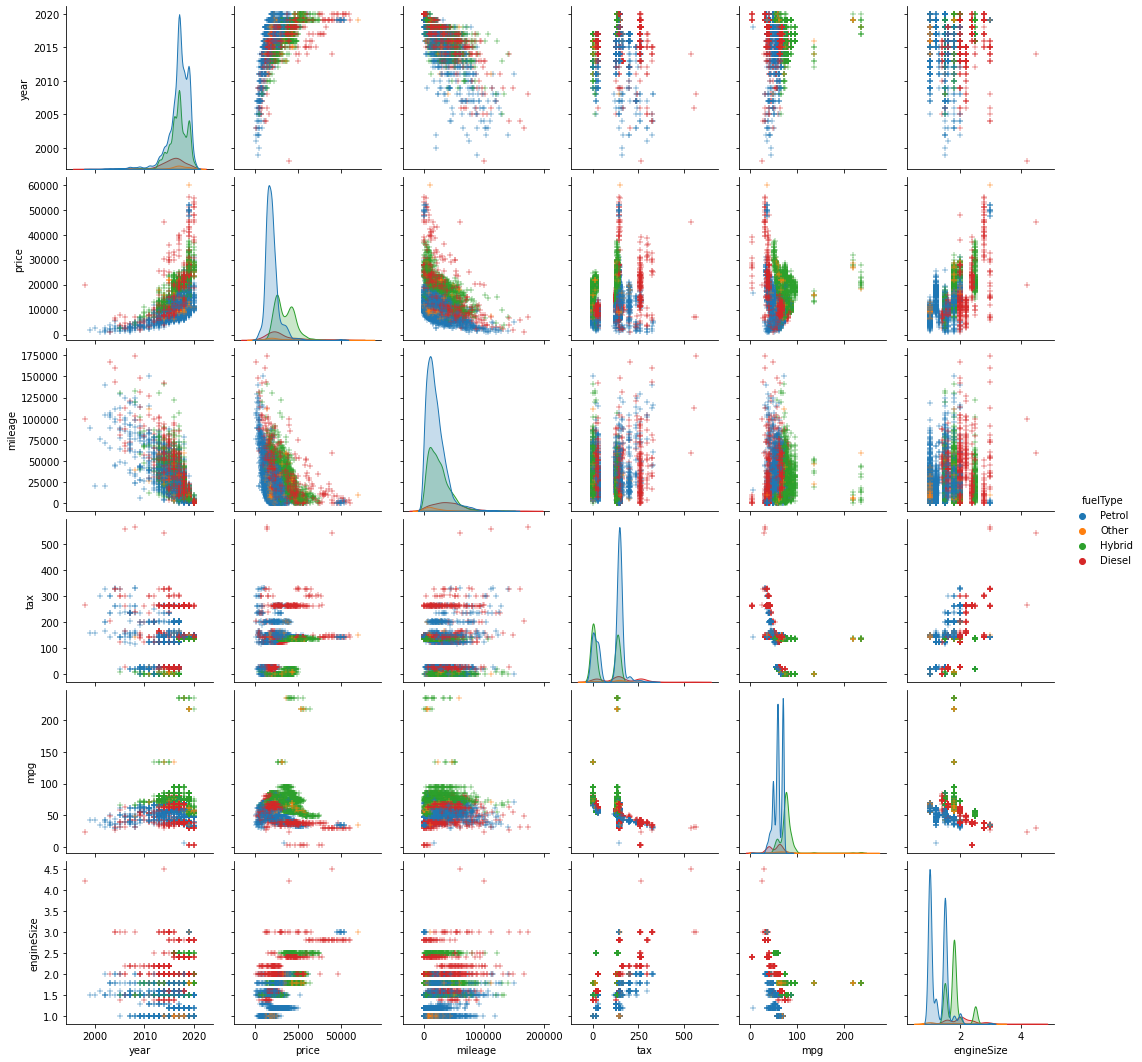

In [12]:
## Libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(df, diag_kind='kde', markers='+', hue='fuelType')
plt.show()

__Pairplot Observations:__
- year:
    - year v year:
        - Petrol (blue) has the most record in the dataset.
        - Hybrid (green) has the second most recrods.
        - Both Petrol and Hybrid have a bimodal like increase after the mode.  >>> ??? 
    - year v price: 
        - Petrol (blue) have largest spread of year and have on average lower price then other fuel types.
        - Diesel (red) have some in betweens. >>> [ ] Look further into this.
        - Hybrid (green) has a faster price grow curve than petrol.
        - Top price range, especially in latter years, occupy the higher price range.
        - The last few years has more points along the price range indicating more car inventory across the range with latter year model.
    - year v mileage: 
        - Petrol (blue) has a steeper negative slope thus lower average mileage of all fuel types, then diesel/other, then hybrid.
        - Interesting to see that diesel are mostly between 2015-2020 >>> ???
    - year v tax:
        - Hybrid has the lowest tax average, then petrol, then diesel/other. >>> Why do diesel vehicles result in higher tax? 
        - Tax are in tiered brackets >>> [ ] Look into tax prices, are these percentages?
    - year v mpg:
        - Hybrid seems to have a signficiant improvement in mpg over the years.
        - Petrol have the largest spread of years.
        - Diesel is still within the range of 2015-2020.
    - year v engineSize:
        - Diesel tends to be ones with bigger engineSize
        - ??? What are the hybrids that have engineSizes comparable to diesel?
        - Petrol ahve a large spread between engineSizes and years, however, the max engineSize of Petrol does not surpass Diesel.
    - price v price:
        - Petrol has the largest price range.
        - Hybrid price has a bimodal distribution. >>> ???
        - Diesel price has the lowest average. >>> [ ] Does Diesel still have the lowest price if we compare similar cars? (There may be a lot more luxury cars in the petrol subset.)
    - price v mileage:
        - Petrol car price is less sensitive to mileage compared to diesel and hybrid.
        - Hybrid price is most sensitive to mileage. >>> ??? Is this because of battery replacement cost? What would the cost basis be if we adjust for battery cost?
        - ??? Are "other fuel type" price least sensitive to mileage?
    - price vs tax:
        - Don't see any specific kinds of relationship.
        - Hybrid has a lower average in tax than others. >>> ??? Is this because of subsidies?
    - price v mpg:
        - Have a little positive relationship when looking at fuel type: petrol has the lowest price and lowest mpg, but hybrid has higher price and higher mpg.
    - price v engineSize: 
        - There is an increasing price with increasing engineSize trend.
        - ??? Why does hybrid have higher cost and higher engineSize?
        - Diesel has larger engineSize than petrol without much increase in price.
    - mileage v mileage:
        - Diesel mileage distribution's center is better than others.
        - ??? How come we're not seeing a strong distribution shift for hybrid? >>> ??? Would we see this shift if we were to exclude the high performance cars from the petrol subset?
    - mileage v tax: 
        - Hybrid dominated the lowest tax bracket here and also has a large spread of mileage indicating the regardless of mileage, hybrid have lower taxes.
        - Petrol occupies the midsection of the tax bracket.
        - Diesel occupies the highest section of the tax bracket. >>> Do diesel fuel have lower tax costs? If not why would buyers be more willing to put up with the higher diesel vehicle costs?
    - mileage v engineSize
        - Unlike other features against engineSize, mileage have very similar spreads across each fuel types.
        - Petrol still has the smallest engineSize, then Hybrid, then Diesel. >>> ??? Is it the way engineSize is being accounted for that is resulting in Hybrid engines having larger size than Petrol?
- tax:
    - tax v tax:
        - Bimodal distribution for both Petrol and Hybrid vehicles.
        - ??? Why does does Petrol's bimodal distribution have different size?
    - tax v mpg: 
        - Seems to show the negative correlation between the two.
        - Hybrid vehicles have two tax groups. >>> ??? Why?
    - tax v engineSize:
        - Shows somewhat positive correlation between tax and engineSize.
        - We can see that Diesel vehicles have larger tax and engineSize on average.
- mpg:
    - mpg v mpg: 
        - Multimodal distributions. >>> ??? Why is that there are multimodel distributions?
        - Hybrid vehicles have higher mean than the Petrol vehicles. 
    - mpg v engineSize:
        - Shows a negative correlation between mpg and engineSize.
        - Hybrid has a higher mpg mean than Diesel, and Diesel has higher mpg mean than Petrol.
- engineSize: 
    - engineSize v engineSize: 
        - Multimodal distribution (perhaps because engineSize is by discrete counts of cylinders.)
        - Diesel has the largest average engineSize, then Hybrid, then Petrol.

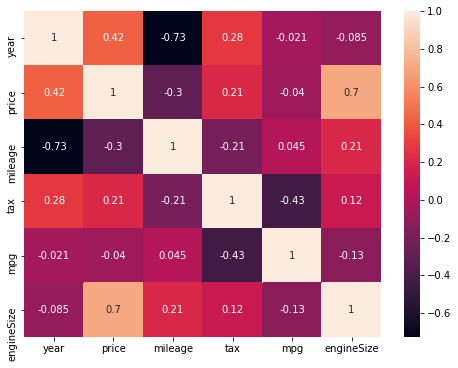

In [13]:
### Correlation heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, ax=ax)
plt.show()  # Show the plot


In [14]:
### Turn correlation matrix from matrix to a long format
corr = df.corr()
mask = np.triu(np.ones(corr.shape)).astype(np.bool)
corr = corr.where(mask)  # Upper corner triangular matrix mask
corr = corr.stack().reset_index()  # Stack to turn the wide matrix to a long dataframe
corr.columns = ['Row', 'Column', 'Correlation']  # Rename columns
corr = corr[corr.Row != corr.Column]  # Remove self correlation
corr = corr.sort_values(by='Correlation', ascending=False)  # Sort by correlation values
display(corr)

,Row,Column,Correlation
10,price,engineSize,0.701674
1,year,price,0.420958
3,year,tax,0.283454
8,price,tax,0.214479
14,mileage,engineSize,0.207246
17,tax,engineSize,0.124723
13,mileage,mpg,0.045083
4,year,mpg,-0.020592
9,price,mpg,-0.039872
5,year,engineSize,-0.084572


__Observations of correlation heatmap:__

Correlation ranges between +1 and -1, thus we are interested in both the lightest and darkest colors.

- Lightest colors (positive correlations):
    - engineSize and price correlation = 0.73
    - year and price correlation = 0.42
    - year and tax correlation 0.28
- Darkest colors (negative correlations):
    - year and mileage correlation = -0.73
    - tax and mpg correlation = -0.43
    - price and mileage correlation = -0.30
    
__Notes:__
- tax may be storngly dependent on year.
- price may also be most strongly dependent on year (positive correlation).
- price may also be strongly dependent on mileage (negative correlation).
- price has a stronger correlation with year than with mileage, perhaps 'year' would have more predictive power.
- mileage may be strongly dependent on year; telling me that the average miles per year is a good enough metric.
- tax is strongly dependent on mpg.


In [15]:
### Reviewing the numbers

display(df.describe())  # Numeric features
display(df.describe(include=np.object))  # Object features

,year,price,mileage,tax,mpg,engineSize
count,6737.000000,6737.000000,6737.000000,6737.000000,6737.000000,6737.000000
mean,2016.748107,12522.127208,22853.894018,94.689773,63.044590,1.496853
std,2.204224,6345.451578,19124.700972,73.883717,15.836694,0.426810
min,1998.000000,850.000000,2.000000,0.000000,2.800000,1.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,55.400000,1.000000
50%,2017.000000,10795.000000,18512.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31060.000000,145.000000,69.000000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000


,model,transmission,fuelType
count,6737,6737,6737
unique,18,4,4
top,Yaris,Manual,Petrol
freq,2122,3825,4086


## Cleaning the Data for Model Training

### OHE or Dummify Categorical Variables (`model`, `transmission`, `fuelType`)

In [16]:
df = pd.get_dummies(df, columns=['model', 'transmission', 'fuelType'])  # One Hot Encoding / Dummify
display(df)

,year,price,mileage,tax,mpg,engineSize,model_Auris,model_Avensis,model_Aygo,model_C-HR,...,model_Verso-S,model_Yaris,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2016,16000,24089,265,36.2,2.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,2017,15995,18615,145,36.2,2.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,2015,13998,27469,265,36.2,2.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,2017,18998,14736,150,36.2,2.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2017,17498,36284,145,36.2,2.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6733,2011,5500,30000,20,58.9,1.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
6734,2011,4985,36154,125,50.4,1.3,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
6735,2012,4995,46000,125,57.6,1.4,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
6736,2011,3995,60700,125,50.4,1.3,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


### Preparing Feature/Target and Train/Test Split

In [17]:
from sklearn.model_selection import train_test_split

## Feature set and Target set 
X = df.loc[:, df.columns!='price']  # Exclude `price`
y = df.loc[:, 'price']

## Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Sanity check
# display(X_train, y_train)

## Checking for curse of dimensionality
print(f"Rows:Columns ratio: {X_train.shape[0] / X_train.shape[1]}")  # There are 173 rows per column, so we should be good 

Rows:Columns ratio: 173.83870967741936


## Model Trainings

In [18]:
### Ignore: Variable to store model results
import pandas as pd

modelResults = pd.DataFrame()

### Model #1 - Simple Regression (Multi-Linear, Lasso Regression)

We start with the most simple regression, and tested for the R2 (Residual-squared) performance metric using cross validation on both the train and test set. 
Through the results below, we are seeing strong variance capturing (measured using R2). The CV=10 R2 score on the training set is approximately 0.926 and 0.927 on the test set, indicating that ~92% of the variance is captured and can be interpreted as ~92% of the information in the training data is captured by this multi-linear regression model.

Further, when we rank the linear regression absolute-coefficient in decreasing magnitude, we can see that car model has a large impact (interpreted through the large coefficient in a linear model). The effect of car model works both ways in increasing the price and decreasing the price of the car. For example, the Toyota Supra is a coveted super car, has a regression coefficient of 23828.770, then the Toyota Land Cruiser with a regression coefficient of 14870.266, and known rugged vehicle suitable for heavy duty workload and considered to be at the same quality as a Lexus (the luxury sub-brand of Toyota).

On the other hand, the Toyota Aygo, Yaris, Auris have a negative regression coefficinet, aligning with them being these models being the mass-market compact-economy vehicles for a demographic that has heavy environmental regulations and high fuel cost.

When soring by the Pearson coefficient against the target variable (price), we see the top four variables being characterisics of a car as opposed to the model. We see engineSize, transmission_Automatic (binary variable), fuelType_Hybrid (binary variable), and year to be the top four correlating variables to price. 
This is indicating that these may be good variables to focus on when we are attempting to build a generalizable model to predict price for used vehicles beyond Toyota.Further, when we rank the linear regression absolute-coefficient in decreasing magnitude, we can see that car model has a large impact (interpreted through the large coefficient in a linear model). The effect of car model works both ways in increasing the price and decreasing the price of the car. For example, the Toyota Supra is a coveted super car, has a regression coefficient of 23828.770, then the Toyota Land Cruiser with a regression coefficient of 14870.266, and known rugged vehicle suitable for heavy duty workload and considered to be at the same quality as a Lexus (the luxury sub-brand of Toyota).

On the other hand, the Toyota Aygo, Yaris, Auris have a negative regression coefficinet, aligning with them being these models being the mass-market compact-economy vehicles for a demographic that has heavy environmental regulations and high fuel cost.

When soring by the Pearson coefficient against the target variable (price), we see the top four variables being characterisics of a car as opposed to the model. We see engineSize, transmission_Automatic (binary variable), fuelType_Hybrid (binary variable), and year to be the top four correlating variables to price. 
This is indicating that these may be good variables to focus on when we are attempting to build a generalizable model to predict price for used vehicles beyond Toyota.

In [19]:
### Linear Regression Fitting
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import r_regression
from sklearn.model_selection import cross_val_score

clf_lr = LinearRegression().fit(X_train, y_train)  # Fit linear regression model

## R2 Score using cross-validation
lr_cv_r2_train = cross_val_score(LinearRegression(),
                                 X = X_train,
                                 y = y_train,
                                 cv = 10)
lr_cv_r2_test = cross_val_score(LinearRegression(),
                                 X = X_test,
                                 y = y_test,
                                 cv = 10)
print(f"Linear Regression mean CV R2 score (train): {np.nanmean(lr_cv_r2_train)}")
print(f"Linear Regression mean CV R2 score (test): {np.nanmean(lr_cv_r2_test)}")

## Linear Regression Coefficients
# print(f"Linear Regression Coef: {clf_lr.coef_}")
# print(f"Linear Regression abs Coef: {abs(clf_lr.coef_)}")

## Pearson coefficients
pearson_coef = r_regression(X_train, y_train)

## Coalesce into Dataframe
clf_lr_results = pd.DataFrame({'variable':X_train.columns,
                               'linear regression coef': clf_lr.coef_,
                               'linear regression abs coef': abs(clf_lr.coef_),
                               'pearson coef': pearson_coef})
display(clf_lr_results)  # Show the dataframe

## Sort by different columns
for col in clf_lr_results.columns:
    sorted_df = clf_lr_results.sort_values(by=col, ascending=False).head(10)
    print(f"Descending sort by '{col}'")
    # print(f"Top variables: \n{sorted_df['variable']}")
    display(sorted_df)
    

## Append Results to modelResults
temp = pd.DataFrame({'model': ['LinearRegression'],
                     'train_R2': [np.nanmean(lr_cv_r2_train)],
                     'test_R2': [np.nanmean(lr_cv_r2_test)]})
modelResults = pd.concat([modelResults, temp])

### NOTES:
## - R2 value on the trained set is very high, 0.926
## - Very interesting that car models have strong linear regression weights, 
##   but other car features have strong Pearson correlation coefficient to price.

Linear Regression mean CV R2 score (train): 0.9276329638992451
Linear Regression mean CV R2 score (test): 0.9098105288272519


,variable,linear regression coef,linear regression abs coef,pearson coef
0,year,8.215580e+02,8.215580e+02,0.422690
1,mileage,-6.117264e-02,6.117264e-02,-0.297902
2,tax,-3.106702e+00,3.106702e+00,0.222917
3,mpg,-6.746275e+00,6.746275e+00,-0.041342
4,engineSize,3.586290e+03,3.586290e+03,0.712259
5,model_Auris,-5.726498e+03,5.726498e+03,0.000589
6,model_Avensis,-4.551478e+03,4.551478e+03,-0.053769
7,model_Aygo,-8.126234e+03,8.126234e+03,-0.468763
8,model_C-HR,-2.284780e+02,2.284780e+02,0.352703
9,model_Camry,4.930983e+02,4.930983e+02,0.100975


Descending sort by 'variable'


,variable,linear regression coef,linear regression abs coef,pearson coef
0,year,8.215580e+02,8.215580e+02,0.422690
26,transmission_Semi-Auto,4.672141e+02,4.672141e+02,0.078097
25,transmission_Other,-1.364242e-12,1.364242e-12,NaN
24,transmission_Manual,-8.670303e+02,8.670303e+02,-0.535974
23,transmission_Automatic,3.998162e+02,3.998162e+02,0.512552
2,tax,-3.106702e+00,3.106702e+00,0.222917
3,mpg,-6.746275e+00,6.746275e+00,-0.041342
22,model_Yaris,-7.508988e+03,7.508988e+03,-0.211888
21,model_Verso-S,-5.160481e+03,5.160481e+03,-0.024951
20,model_Verso,-4.581344e+03,4.581344e+03,-0.008590


Descending sort by 'linear regression coef'


,variable,linear regression coef,linear regression abs coef,pearson coef
18,model_Supra,23710.063098,23710.063098,0.255997
14,model_Land Cruiser,16146.310113,16146.310113,0.347347
15,model_PROACE VERSO,7497.721786,7497.721786,0.123857
4,engineSize,3586.290122,3586.290122,0.712259
12,model_Hilux,2197.264036,2197.264036,0.170457
28,fuelType_Hybrid,1230.409226,1230.409226,0.477767
29,fuelType_Other,947.143527,947.143527,0.029704
0,year,821.557978,821.557978,0.422690
9,model_Camry,493.098306,493.098306,0.100975
26,transmission_Semi-Auto,467.214138,467.214138,0.078097


Descending sort by 'linear regression abs coef'


,variable,linear regression coef,linear regression abs coef,pearson coef
18,model_Supra,23710.063098,23710.063098,0.255997
14,model_Land Cruiser,16146.310113,16146.310113,0.347347
7,model_Aygo,-8126.233966,8126.233966,-0.468763
22,model_Yaris,-7508.988346,7508.988346,-0.211888
15,model_PROACE VERSO,7497.721786,7497.721786,0.123857
13,model_IQ,-5964.973224,5964.973224,-0.032201
5,model_Auris,-5726.498235,5726.498235,0.000589
19,model_Urban Cruiser,-5435.961293,5435.961293,-0.033598
21,model_Verso-S,-5160.480812,5160.480812,-0.024951
20,model_Verso,-4581.344032,4581.344032,-0.008590


Descending sort by 'pearson coef'


,variable,linear regression coef,linear regression abs coef,pearson coef
4,engineSize,3586.290122,3586.290122,0.712259
23,transmission_Automatic,399.816178,399.816178,0.512552
28,fuelType_Hybrid,1230.409226,1230.409226,0.477767
0,year,821.557978,821.557978,0.422690
8,model_C-HR,-228.478014,228.478014,0.352703
14,model_Land Cruiser,16146.310113,16146.310113,0.347347
10,model_Corolla,-902.649576,902.649576,0.263434
18,model_Supra,23710.063098,23710.063098,0.255997
17,model_RAV4,-1322.693821,1322.693821,0.240952
2,tax,-3.106702,3.106702,0.222917


### Model #2 - Decision Tree regression

The second model, we use a Decision Tree regressor, and after hyperparameter tuning, we're able to improve our R2 score from 0.912 on a testing dataset to 0.945 to 0.961.

The decision tree has more predictive power than the regression, and it may be due to that the decision tree is more complex and able to handle the sparsely distributed component of the dummified component of the categorical variables (e.g. model/transmission/fuelType).

In [21]:
### Decision Tree with Default hyperparameters

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score

## Default Decision Tree
clf_dt_default = DecisionTreeRegressor(criterion='squared_error').fit(X_train, y_train)

clf_dt_default.score(X_train, y_train)  # R2-score (train)
clf_dt_default.score(X_test, y_test)    # R2-score (test)

## CV scores
dt_cv_r2_train = cross_val_score(clf_dt_default,
                                 X_train, y_train,
                                 cv=10)
dt_cv_r2_test = cross_val_score(clf_dt_default,
                                X_test, y_test,
                                cv=10)
print(f"Default DT cv mean R2 score (train): {np.nanmean(dt_cv_r2_train)}")
print(f"Default DT cv mean R2 score (test): {np.nanmean(dt_cv_r2_test)}")

## Plot the decision tree (may time out)
# plot_tree(clf_dt_default)
# plt.show()

## Append Results to modelResults
temp = pd.DataFrame({'model': ['DecisionTree (untuned)'],
                     'train_R2': [clf_dt_default.score(X_train, y_train)],
                     'test_R2': [clf_dt_default.score(X_test, y_test)], 
                     'train_CV_R2': [np.nanmean(dt_cv_r2_train)],
                     'test_CV_R2': [np.nanmean(dt_cv_r2_test)]})
modelResults = pd.concat([modelResults, temp])


Default DT cv mean R2 score (train): 0.9359548250725214
Default DT cv mean R2 score (test): 0.8834282020722926


In [22]:
### Tune the DecisionTree hyperparameters

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

params = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
          'max_depth': ['None']+list(np.arange(1, 200, 5)),
          'min_samples_split': np.arange(2, 50, 5),
          'max_features': ['None', 'auto', 'sqrt', 'log2'],
          'min_impurity_decrease': np.arange(0, 100, 5),
          'ccp_alpha': np.arange(0, 100, 5)}

rand_search_dt = RandomizedSearchCV(DecisionTreeRegressor(),
                                   params,
                                   n_iter=20,
                                   cv=5).fit(X_train, y_train)

print(f"Tuned DT best R2-score (train): {rand_search_dt.best_score_}")
print(f"Tuned DT R2-score (test): {rand_search_dt.best_estimator_.score(X_test, y_test)}")
print(f"Tuned DT Best params: {rand_search_dt.best_params_}")

# print("RandomizedSearchCV Results:")
# display(pd.DataFrame(rand_search_dt.cv_results_)
#         .sort_values(by='rank_test_score')
#         .head())

## Mean of all RandomizedSearchCV mean_test_score
# print(f"Mean of all RandomizedSearchCV mean_test_scores: {np.nanmean(pd.DataFrame(rand_search_dt.cv_results_)['mean_test_score'])}")

## Append Results to modelResults
temp = pd.DataFrame({'model': ['DecisionTree (tuned)'],
                     'train_R2': [rand_search_dt.best_score_],
                     'test_R2': [rand_search_dt.best_estimator_.score(X_test, y_test)]})
modelResults = pd.concat([modelResults, temp])

Tuned DT best R2-score (train): 0.9504120953902593
Tuned DT R2-score (test): 0.9480293391021437
Tuned DT Best params: {'min_samples_split': 27, 'min_impurity_decrease': 10, 'max_features': 'auto', 'max_depth': 96, 'criterion': 'squared_error', 'ccp_alpha': 95}


### Model #3 - AdaBoost Regression (Decision tree ensemble)

Since the decision tree regressor has shown to capture a high amount of information in terms of R2 value, I am interestd in seeing if we can improve the prediction with an ensemble algorithm (e.g. AdaBoost).

The R2 value on the test dataset for the untuned AdaBoost model is ~0.590, and the tuned R2 value on the test set is ~0.967.
The result is marginally better than that of the decision tree.

In [23]:
### AdaBoost with default hyperparameters and DT-stumps
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

stump = DecisionTreeRegressor(max_depth=1)
clf_ada = AdaBoostRegressor(base_estimator=stump).fit(X_train, y_train)

print(f"Default AdaBoost R2-Score (train): {clf_ada.score(X_train, y_train)}")
print(f"Default AdaBoost R2-Score (test): {clf_ada.score(X_test, y_test)}")

## Append Results to modelResults
temp = pd.DataFrame({'model': ['AdaBoost (untuned)'],
                     'train_R2': [clf_ada.score(X_train, y_train)],
                     'test_R2': [clf_ada.score(X_test, y_test)]})
modelResults = pd.concat([modelResults, temp])

Default AdaBoost R2-Score (train): 0.5143145875977052
Default AdaBoost R2-Score (test): 0.4382316380436049


In [24]:
### AdaBoost with hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
import numpy as np

param_dict = {'base_estimator__max_depth': np.arange(1, 10, 2),
              'base_estimator__min_samples_split': np.arange(2, 10, 2),
              'base_estimator__min_samples_leaf': np.arange(1, 5, 1),
              'base_estimator__min_impurity_decrease': np.arange(0.0, 10.0, 2.0),
              'base_estimator__ccp_alpha': np.arange(0.0, 10.0, 2),
              'n_estimators': np.arange(50, 100, 10),
              'learning_rate': np.arange(1.0, 10, 2),
              'loss': ['linear', 'square', 'exponential']}
clf_ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())

rand_search_ada = RandomizedSearchCV(estimator=clf_ada, 
                         param_distributions=param_dict, 
                         n_iter=10, 
                         cv=5).fit(X_train, y_train)
# print(f"AdaBoost hyperparmaeter tuning results:")
# display(pd.DataFrame(rand_search_ada.cv_results_))
print(f"Tuned AdaBoost best R2-score (train): {rand_search_ada.best_score_}")
print(f"Tuned AdaBoost R2-score (test): {rand_search_ada.best_estimator_.score(X_test, y_test)}")
print(f"Tuned AdaBoost best param: {rand_search_ada.best_params_}")


## Append Results to modelResults
temp = pd.DataFrame({'model': ['AdaBoost (tuned)'],
                     'train_R2': [rand_search_ada.best_score_],
                     'test_R2': [rand_search_ada.best_estimator_.score(X_test, y_test)]})
modelResults = pd.concat([modelResults, temp])

Tuned AdaBoost best R2-score (train): 0.9601357759039162
Tuned AdaBoost R2-score (test): 0.9536080286237474
Tuned AdaBoost best param: {'n_estimators': 60, 'loss': 'exponential', 'learning_rate': 3.0, 'base_estimator__min_samples_split': 4, 'base_estimator__min_samples_leaf': 3, 'base_estimator__min_impurity_decrease': 8.0, 'base_estimator__max_depth': 9, 'base_estimator__ccp_alpha': 4.0}


### Model #4 - Random forest regression (Decision tree ensemble)

Instead of a serialized ensemble algorithm, I am trying to imprpove the Decision Tree Regressor with a parallel ensemble algorithm using the Random Forest.

With an untuned RF, we are able to achieve an R2 score of 0.970 on the test dataset; however, the R2 score on the train and test set decreased to 0.885 and 0.890 respectively when we attempt to tune the hyperparameters.

Perhaps this is due to the random feature selection of Random Forest?

In [26]:
### Random forest regressor with defualt hyperparameters
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

## Fit the default parameter RF model
clf_rf_default = RandomForestRegressor().fit(X_train, y_train)
print(f"Default RF R2-score (train): {clf_rf_default.score(X_train, y_train)}")
print(f"Default RF R2-score (test): {clf_rf_default.score(X_test, y_test)}")
print(f"Default RF params: {clf_rf_default.get_params()}")

## Check the cross validation score
clf_rf_default_cv_score_train = cross_val_score(estimator=clf_rf_default, 
                                               X = X_train,
                                               y = y_train, 
                                               cv=5)
clf_rf_default_cv_score_test = cross_val_score(estimator=clf_rf_default, 
                                                X = X_test,
                                                y = y_test, 
                                                cv=5)
print(f"Default RF CV R2-score (train): {np.nanmean(clf_rf_default_cv_score_train)}")
print(f"Default RF CV R2-score (test): {np.nanmean(clf_rf_default_cv_score_test)}")


## Append Results to modelResults
temp = pd.DataFrame({'model': ['RandomForest (untuned)'],
                     'train_R2': [clf_rf_default.score(X_train, y_train)],
                     'test_R2': [clf_rf_default.score(X_test, y_test)],
                     'train_CV_R2': [np.nanmean(clf_rf_default_cv_score_train)],
                     'test_CV_R2': [np.nanmean(clf_rf_default_cv_score_test)]})
modelResults = pd.concat([modelResults, temp])

Default RF R2-score (train): 0.9947611392567132
Default RF R2-score (test): 0.958547756322987
Default RF params: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Default RF CV R2-score (train): 0.9624953817696941
Default RF CV R2-score (test): 0.9282313228117157


In [27]:
### RF Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dict = {'n_estimators': np.arange(20, 150, 10),
              'criterion': ['sqaured_error', 'absolute_error'],
              'max_depth': np.arange(1, 100, 5),
              'min_samples_split': np.arange(2, 50, 5), 
              'min_samples_leaf': np.arange(1, 50, 5),
              'max_features': ['sqrt', 'log2'],
              'min_impurity_decrease': np.arange(0, 100, 5)}

rand_search_rf = RandomizedSearchCV(RandomForestRegressor(), 
                                    param_distributions=param_dict,
                                    n_iter=20,
                                    cv=5).fit(X_train, y_train)

print(f"Tuned RF best R2-score (train): {rand_search_rf.best_score_}")
print(f"Tuned RF R2-score (test): {rand_search_rf.best_estimator_.score(X_test, y_test)}")
print(f"Tuned RF best param: {rand_search_rf.best_params_}")
# print("RandomizedSearchCV Results:")
# display(pd.DataFrame(rand_search_rf.cv_results_)
#         .sort_values(by='rank_test_score')
#         .head())

## Mean of all RandomizedSearchCV mean_test_score
print(f"Mean of all RandomizedSearchCV mean_test_scores: {np.nanmean(pd.DataFrame(rand_search_rf.cv_results_)['mean_test_score'])}")

## Append Results to modelResults
temp = pd.DataFrame({'model': ['RandomForest (tuned)'],
                     'train_R2': [rand_search_rf.best_score_],
                     'test_R2': [rand_search_rf.best_estimator_.score(X_test, y_test)]})
modelResults = pd.concat([modelResults, temp])

Tuned RF best R2-score (train): 0.9409383192916687
Tuned RF R2-score (test): 0.9428758886955951
Tuned RF best param: {'n_estimators': 60, 'min_samples_split': 27, 'min_samples_leaf': 1, 'min_impurity_decrease': 0, 'max_features': 'sqrt', 'max_depth': 96, 'criterion': 'absolute_error'}
Mean of all RandomizedSearchCV mean_test_scores: 0.6781894260782013


### Model #5 - SVM (Support Vector Regressor)

Lastly, I attempt to model using SVM, which is just an attempt as the sparsely distributed feature matrix would not provide enough density for the determination of the support  vector in an SVM algorithm.

Perhaps there are rooms for improvements here?

In [28]:
### SVM with default hyperparameters
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## Building an SVR pipeline (SVM needs to normalize inlineputs)
svr_pipeline = make_pipeline(StandardScaler(), SVR())
clf_svr_default = svr_pipeline.fit(X_train, y_train)
print(f"Default SVR score (R2) (train): {clf_svr_default.score(X_train, y_train)}")  # Wow, very bad
print(f"Default SVR score (R2) (test): {clf_svr_default.score(X_test, y_test)}")     # Bad, but better than the train set, why?

## Append Results to modelResults
temp = pd.DataFrame({'model': ['SVM (untuned)'],
                     'train_R2': [clf_svr_default.score(X_train, y_train)],
                     'test_R2': [clf_svr_default.score(X_test, y_test)]})
modelResults = pd.concat([modelResults, temp])

Default SVR score (R2) (train): 0.007696732816725671
Default SVR score (R2) (test): 0.015125434881340882


In [30]:
### SVM Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
import warnings
import numpy as np

## Ignore all warnings
warnings.filterwarnings('ignore')

## Hyperparamter tuning 
param_dist = {'svr__kernel':['linear', 'poly', 'rbf'],
              'svr__degree': range(3, 6), 
              'svr__C': range(1, 5),
              'svr__max_iter': range(5, 10)}
## RandomizedSearchCV (hyperparameter tuning)
rand_search_svr = (RandomizedSearchCV(estimator=clf_svr_default, 
                                 param_distributions=param_dist, 
                                 n_iter=20,
                                 cv=5)).fit(X_train, y_train)
print(f"Tuned SVR best R2-score (train): {rand_search_svr.best_score_}")
print(f"Tuned SVR R2-score (test): {rand_search_svr.best_estimator_.score(X_test, y_test)}")
print(f"Tuned SVR best param: {rand_search_svr.best_params_}")
# print(f"RandomizedSearchCV Results:")
# display(pd.DataFrame(rand_search_svr.cv_results_)
#         .sort_values(by='rank_test_score')
#         .head())

## Mean of all RandomizedSearchCV mean_test_score
print(f"Mean of all RandomizedSearchCV mean_test_scores: {np.nanmean(pd.DataFrame(rand_search_svr.cv_results_)['mean_test_score'])}")

## NOTES:
## - Yeah, the score does not look good. Perhaps SVR is not a good model as the matrix is pretty sparse 
##   from the different car models and fueltTypes.

## Append Results to modelResults
temp = pd.DataFrame({'model': ['SVM (tuned)'],
                     'train_R2': [rand_search_svr.best_score_],
                     'test_R2': [rand_search_svr.best_estimator_.score(X_test, y_test)]})
modelResults = pd.concat([modelResults, temp])

Tuned SVR best R2-score (train): -3.124257258725593
Tuned SVR R2-score (test): -3.614366532401557
Tuned SVR best param: {'svr__max_iter': 8, 'svr__kernel': 'poly', 'svr__degree': 5, 'svr__C': 2}
Mean of all RandomizedSearchCV mean_test_scores: -4.6169070095201965


## Model Comparisons

In [40]:
display(modelResults.reset_index(drop=True).sort_values(by='test_R2', ascending=False))

,model,train_R2,test_R2,train_CV_R2,test_CV_R2
6,RandomForest (untuned),0.994761,0.958548,0.962495,0.928231
5,AdaBoost (tuned),0.960136,0.953608,NaN,NaN
3,DecisionTree (tuned),0.950412,0.948029,NaN,NaN
7,RandomForest (tuned),0.940938,0.942876,NaN,NaN
2,DecisionTree (untuned),0.999848,0.935710,0.935955,0.883428
1,DecisionTree (untuned),0.999848,0.935063,0.936213,0.885365
0,LinearRegression,0.927633,0.909811,NaN,NaN
4,AdaBoost (untuned),0.514315,0.438232,NaN,NaN
8,SVM (untuned),0.007697,0.015125,NaN,NaN
9,SVM (tuned),-3.124257,-3.614367,NaN,NaN


## Application: 
- Wrap the trained model into a function prompting the users to input characteristics about the car (i.e. model, transmission type, fuel type, etc.)
- Pikle and export the function.
- Write a BASH script that loads the environment and function when the user downloads the script.

## Future Improvement Ideas:
- Incorporate similar data but for other car manufacturers as car brand is intuitively known to have an impact on the willingness a customer is willing to pay for a car.
- Include CarFax location history of a vehicle (Hypothesis: cars in ares with road salt can decrease the desirability of the car.)
- Attempt to improve the SVM on numerical variables only.